In [1]:
import numpy as np
import xarray as xr
import os.path as op
import scipy.interpolate as intp
from xmitgcm import open_mdsdataset
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp2d, PchipInterpolator
from matplotlib.colors import from_levels_and_colors as flc
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
res = 2e0 #km

# set output_directory to save input files. 
output_dir = '/rigel/ocp/users/tu2140/chkp63n/MITgcm/Southern-Ocean/channel_flat/input/'

# set format of binary files 
tp = '>f8'

In [3]:
# function that makes xy grid
def make_grid_xy(nx,ny, lengthx=1.0e6, lengthy=2.0e6):
    lx, ly = lengthx, lengthy
    # nx, ny = n, n
    dx, dy = lx/nx, ly/ny

    # create mesh-grids for cell centers
    xc, yc = np.meshgrid(
                dx * np.arange(nx) + dx/2,
                dy * np.arange(ny) + dy/2)
    
    return xc, yc

In [4]:
# domain width and length (currently using a square)
Ly = 2.0e6
Lx = 1.0e6

# number of center grid points (how many dx fit in the domain)
nx = int(Lx/res/1000)
ny = int(Ly/res/1000)

# generate the x,y grid
xc, yc = make_grid_xy(nx,ny, Lx,Ly)

In [5]:
dzhigh = np.array([1.00,    1.14,    1.30,    1.49,   1.70,
                  1.93,    2.20,    2.50,    2.84,   3.21,
                  3.63,    4.10,    4.61,    5.18,   5.79,
                  6.47,    7.20,    7.98,    8.83,   9.73,
                  10.69,   11.70,   12.76,   13.87,  15.03,
                  16.22,   17.45,   18.70,   19.97,  21.27,
                  22.56,   23.87,   25.17,   26.46,  27.74,
                  29.00,   30.24,   31.45,   32.65,  33.82,
                  34.97,   36.09,   37.20,   38.29,  39.37,
                  40.45,   41.53,   42.62,   43.73,  44.87,
                  46.05,   47.28,   48.56,   49.93,  51.38,
                  52.93,   54.61,   56.42,   58.38,  60.53,
                  62.87,   65.43,   68.24,   71.33,  74.73,
                  78.47,   82.61,   87.17,   92.21,  97.79,
                  103.96,  110.79,  118.35,  126.73, 136.01, 174.67])
dzlow = np.append(np.array([10.0, 10.0, 10.0, 12.0, 14.0, 
                  16.0, 19.0, 22.0, 26.0, 30.0, 
                  36.0, 42.0, 50.0, 60.0, 72.0, 85., 102.]), 103.*np.ones(23))
nz = len(dzhigh)
nz

76

In [17]:
ddir = '/rigel/ocp/users/tu2140/chkp63n/MITgcm/Southern-Ocean/channel_flat/input/'
sosedir = '/swot/SUM05/takaya/SOSE/5day_ave/dyn'

# Topographic shape
Large scale shape of topography - flat bottom ($h_0=0$)

$$ bathy = -H + h_b = -H + h_0 e^{-x^2/\sigma^2} $$

With $H = 2985$ m, $h_0 = 927$ m and $\sigma = 75$ km.
(The particular numbers are chosen to match Ryan's previous experiments, and also work with the vertical grid)

In [36]:
H  = 2985.0
h0 = 0.
sig= 75.0e3

bathy      = -(H - h0*np.exp(-(xc - Lx/2)**2 / sig**2))
bathy[:,:] = -H
bathy[0,:] = 0.0 # create a wall to the south. By default MITgcm assumes periodic in both directions.

In [37]:
print(bathy.shape)
bathy.astype(tp).tofile(output_dir + 'BATHY_flat_bump_deep%03dkm.bin' % res)

(1000, 500)


# Wind conditions
We use an atmospheric jet as the wind forcing. This condition diverges slightly from Ryan's previous runs, as generate a jet that is more focussed in the center (change from $sin(y)$ to $sin^2(y)$).

$$ \tau = \tau_0 sin^2(\pi y/L_y) $$

In order to add the binomial seasonality, we change the value of $\tau_0$.

In [18]:
# tau0 = 0.2
ds = xr.open_dataset(op.join(sosedir,'SOSE-windstress_monclim-5Dave.nc'))
Stau = ds.tau
Stau

<xarray.DataArray 'tau' (iDinY: 73, iY: 320, iX: 2160)>
[50457600 values with dtype=float32]
Coordinates:
  * iY       (iY) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
  * iX       (iX) int64 0 1 2 3 4 5 6 7 ... 2153 2154 2155 2156 2157 2158 2159
    Y        (iY, iX) float64 ...
    X        (iY, iX) float64 ...
  * iDinY    (iDinY) int64 0 1 2 3 4 5 6 7 8 9 ... 63 64 65 66 67 68 69 70 71 72

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


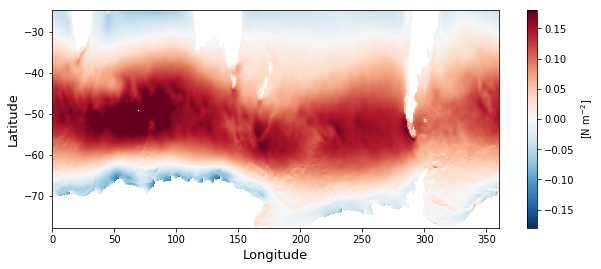

In [19]:
fig, ax = plt.subplots(figsize=(10,4))
# ax.plot(Stau.sel(iY=slice(130,170)).mean(['iY','iX']), 'k', lw=2)
im = ax.pcolormesh(Stau.X, Stau.Y, np.ma.masked_invalid(Stau.mean('iDinY')), 
                  rasterized=True, cmap='RdBu_r',
                  vmin=-.18, vmax=.18)
ax.set_xlabel(r'Longitude', fontsize=13)
ax.set_ylabel(r'Latitude', fontsize=13)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'[N m$^{-2}$]')
# plt.savefig('SOSE-windstressclim.pdf')

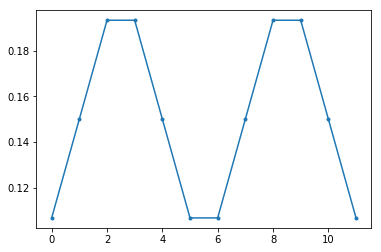

In [7]:
tau_const = 0.15
tau_ideal = tau_const - 0.05*np.cos(np.pi/3*np.arange(0.5,12.5))
plt.plot(tau_ideal, '.-')

In [8]:
# make sure that the wind goes to zero at the north and south boundary within in the domain.
# be careful that one grid point to the south is just land. 
# the way the wind is defined right now, the wavelength changes slightly between runs.
# also make sure that the wind profile looks the same in all the runs with different resolution.

dy = yc[1,1] - yc[0,1]
a = 100e3 # the narrowness of the 
tau = tau_ideal[:,np.newaxis,np.newaxis]*(np.sin(np.pi*(yc-a/2)/(Ly-a))**2) 
tau[:,yc<=a/2] = 0.
tau[:,yc>=(Ly-a/2)] = 0.
# for the presence of land cell at the southern most grid cell.

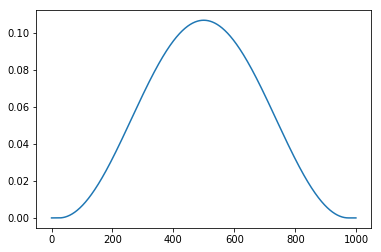

In [9]:
plt.plot(tau[0,:,0])

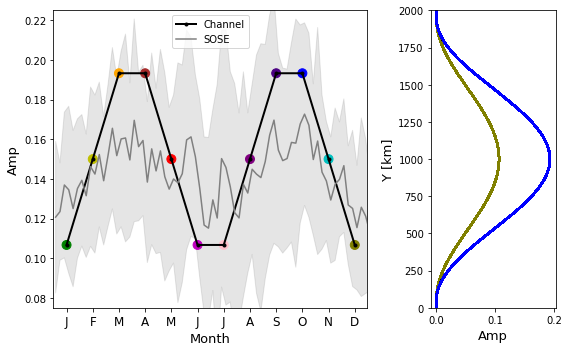

In [21]:
colors = ['g','y','orange','brown','r','m','pink','purple','indigo','b','c','olive']


fig = plt.figure(figsize=(8,5))
gs = gridspec.GridSpec(nrows=1,ncols=6)
ax1 = plt.subplot(gs[:,:4])
ax2 = plt.subplot(gs[:,4:])

ax1.plot(range(15,360,30), tau_ideal, 'k.-', lw=2, label=r'Channel')
ax1.plot(days, Stau.sel(iY=slice(130,170)).mean(['iY','iX']), 
         color='grey', label=r'SOSE')
ax1.fill_between(days, Stau.sel(iY=slice(130,170)).mean(['iY','iX'])-Stau.sel(iY=slice(130,170)).std(['iY','iX']),
                 Stau.sel(iY=slice(130,170)).mean(['iY','iX'])+Stau.sel(iY=slice(130,170)).std(['iY','iX']),
                 color='grey', alpha=0.2)
ax1.scatter(range(15,375,30),tau_ideal,color=colors,s=80)
ax1.set_xlim([0,359])
ax1.set_ylim([0.075,0.225])
ax1.set_xticks(range(15,360,30))
ax1.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'], fontsize=12)
ax1.set_xlabel('Month', fontsize=13)
ax1.set_ylabel('Amp', fontsize=13)

ax2.plot(tau[:,:,0][-1],yc*1e-3,c=colors[-1], lw=2)
ax2.plot(tau[:,:,0][-3],yc*1e-3,c=colors[-3], lw=2)
ax2.set_xlabel('Amp', fontsize=13)
ax2.set_ylabel(r'Y [km]', fontsize=13)
ax2.set_ylim([0,2e3])
ax1.legend(loc='upper center')
plt.tight_layout()
# plt.savefig('SurfaceTau-sin2_seasonality_sinusoid.pdf')

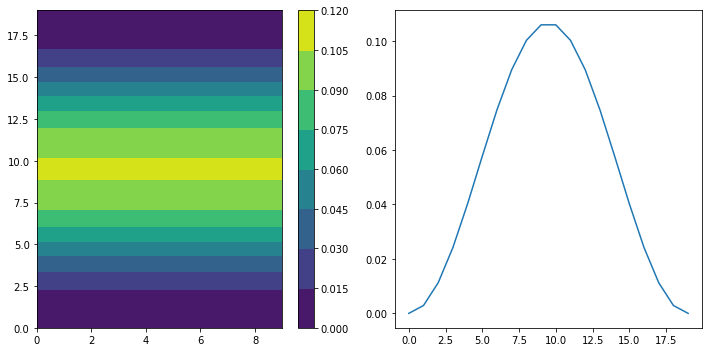

In [9]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.contourf(tau[0])
plt.colorbar()

plt.subplot(1,2,2)
plt.plot(tau[0,:,0],'-')
plt.tight_layout()

In [16]:
print(tau.shape)
fname = output_dir + 'TAU-sin2_seasonal_50km0pad_%03dkm.bin' % res
print(fname)
tau.astype(tp).tofile(fname)

(12, 20, 10)
/rigel/ocp/users/tu2140/chkp63n/MITgcm/Southern-Ocean/channel_flat/input/TAU-sin2_seasonal_50km0pad_100km.bin


# Surface buoyancy conditions
Restore the surface to a linear buoyancy profile (temperature as there is no salt in the simulation)

In [10]:
sst_1 = 1.75*np.cos(np.arange(0.,2*np.pi,2*np.pi/12.))+3.25
sst_2 = 1.75*np.cos(np.arange(0.,2*np.pi,2*np.pi/12.))+4.75

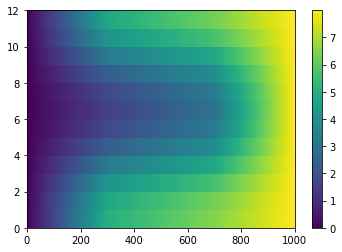

In [11]:
sst = np.zeros((12,ny))
heat = int(.3*ny) 
cool = int(.7*ny)
for i in range(12):
    sst[i,:heat+1] = np.linspace(0.,sst_1[i],heat+1)
    sst[i,heat:cool+1] = np.linspace(sst_1[i],sst_2[i],cool-heat+1)
    sst[i,cool:] = np.linspace(sst_2[i],8.,ny-cool,endpoint=False)

fig, ax = plt.subplots()
cax = ax.pcolormesh(sst)
fig.colorbar(cax)

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


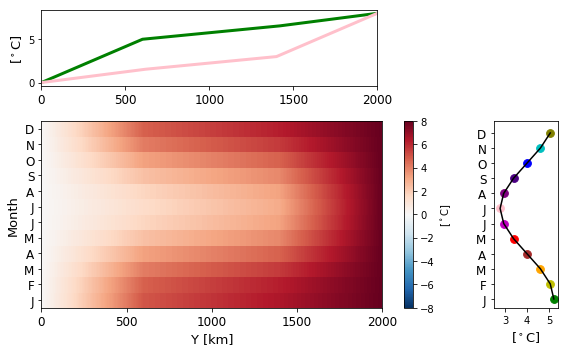

In [12]:
mon = ['J','F','M','A','M','J','J','A','S','O','N','D']
colors = ['g','y','orange','brown','r','m','pink','purple','indigo','b','c','olive']



fig = plt.figure(figsize=(8,5))
fig.set_tight_layout(True)
ax1 = plt.subplot2grid((6,6),(0,0),colspan=4,rowspan=2)
ax2 = plt.subplot2grid((6,6),(2,0),rowspan=4,colspan=5)
ax3 = plt.subplot2grid((6,6),(2,5),rowspan=4)

ax1.plot(np.arange(0,2000,res), sst[0], color=colors[0], lw=3)
ax1.plot(np.arange(0,2000,res), sst[6], color=colors[6], lw=3)
for i in range(12):
    ax3.scatter(sst.mean(axis=-1)[i], np.arange(1,13)[i], s=60., c=colors[i])
ax1.set_xlim([0.,2e3-res])
ax1.set_ylabel(r'[$^\circ$C]', fontsize=13)
im = ax2.pcolormesh(np.arange(0,2000,res), np.arange(13), sst[:], 
                   vmax=8e0, vmin=-8., cmap='RdBu_r', rasterized=True)
ax1.set_xlim([0.,2e3])
ax2.set_xlim([0.,2e3])
ax1.set_xticks(np.array([0,500,1000,1500,2000]))
ax1.set_xticklabels(np.array([0,500,1000,1500,2000]), fontsize=12)
ax2.set_xticks(np.array([0,500,1000,1500,2000]))
ax2.set_xticklabels(np.array([0,500,1000,1500,2000]), fontsize=12)
ax2.set_yticks(np.arange(.5,12.5))
ax2.set_yticklabels(mon, fontsize=12)
ax2.set_ylabel(r"Month", fontsize=13)
ax2.set_xlabel(r"Y [km]", fontsize=13)
ax3.plot(sst.mean(axis=-1), range(1,13), 'k')
ax3.set_xlabel(r'[$^\circ$C]', fontsize=13)
# ax3.set_ylim([1,12])
ax3.set_yticks(range(1,13))
ax3.set_yticklabels(mon, fontsize=12)

cbar = fig.colorbar(im, ax=ax2)
cbar.set_label(r'[$^\circ$C]')

# CAREFUL WITH WHAT YOU SAVE!!!!
Due to having constant SST runs for the 5km run, I screwed it up in the past.

In [22]:
sstsave = sst[:,:,np.newaxis] * np.ones(nx)[np.newaxis,np.newaxis,:]
print(sstsave.shape)
sstsave.astype(tp).tofile((output_dir + 'SST_zerores_rolled_%03dkm.bin' % res))

(12, 1000, 500)


# PAR condition

<xarray.DataArray (days: 365, lat: 300)>
[109500 values with dtype=float64]
Coordinates:
  * days     (days) int64 0 1 2 3 4 5 6 7 8 ... 357 358 359 360 361 362 363 364
  * lat      (lat) float64 -43.38 -43.46 -43.54 -43.63 ... -68.13 -68.21 -68.29

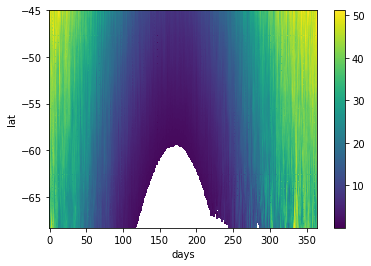

In [26]:
PARvar = xr.open_dataarray('/swot/SUM05/takaya/SeaWiFS/PAR_45-65_SeaWiFS.nc')
PARvar[:,20:].plot(x='days',y='lat')
PARvar

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


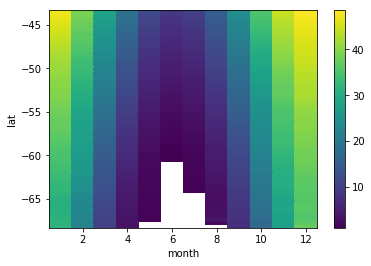

In [28]:
PAR_mon = np.zeros((12,300))
mon_days = {'Jan':range(31),'Feb':range(31,59),'Mar':range(59,90),'Apr':range(90,120),'May':range(120,151),
           'Jun':range(151,181),'Jul':range(181,212),'Aug':range(212,243),'Sep':range(243,273),'Oct':range(273,304),
           'Nov':range(304,334),'Dec':range(334,365)}
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
i = 0
for month in months:
    PAR_mon[i] = np.nanmean(PARvar[mon_days[month][0]:mon_days[month][-1]], axis=0)
    i += 1

PAR_mon = xr.DataArray(PAR_mon, dims=['month','lat'],
                       coords={'month':range(1,13), 'lat':PARvar.lat.data}
                      )

PAR_mon.plot(x='month',y='lat')

In [29]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

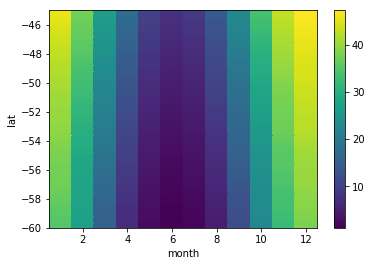

In [30]:
for i in range(12):
    nans, x = nan_helper(PAR_mon[i].data)
    PAR_mon[i,nans] = np.interp(x(nans), x(~nans), PAR_mon.data[i,~nans])
PAR_mon.sel(lat=slice(-45.,-60.)).T.plot()

In [31]:
par_mid = PAR_mon.sel(lat=slice(-45.,-60.)).mean('lat')
func = PchipInterpolator(np.arange(0,14), 
                      np.append(par_mid[-1].values, np.append(par_mid.values, par_mid[0].values)))
par_north = func(np.arange(1,13))+4.5
par_ideal = par_north[:,np.newaxis] + np.linspace(-9.,0,num=ny)[np.newaxis,:]
par_ideal[par_ideal<0.] = 0.
par_ideal.shape

(12, 1000)

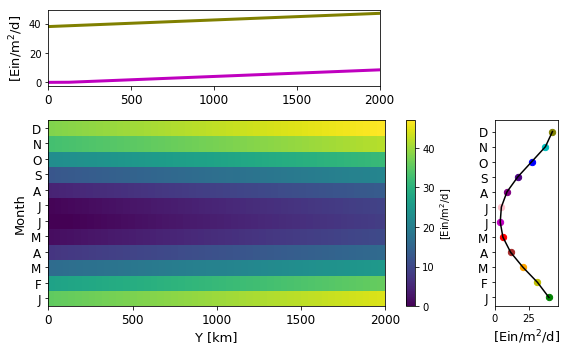

In [32]:
mon = ['J','F','M','A','M','J','J','A','S','O','N','D']
colors = ['g','y','orange','brown','r','m','pink','purple','indigo','b','c','olive']

fig = plt.figure(figsize=(8,5))
gs = gridspec.GridSpec(nrows=3,ncols=6)
ax1 = plt.subplot(gs[0,:4])
ax2 = plt.subplot(gs[1:,:5])
ax3 = plt.subplot(gs[1:,5:])

ax1.plot(np.arange(0,2000,res),par_ideal[5],color=colors[5], lw=3)
ax1.plot(np.arange(0,2000,res),par_ideal[-1],color=colors[-1], lw=3)
for i in range(12):
    ax3.scatter(par_ideal.mean(axis=-1)[i], np.arange(1,13)[i], s=40., c=colors[i])
ax1.set_ylabel(r'[Ein/m$^2$/d]', fontsize=13)
ax1.set_xlim([0.,2e3])
ax2.set_xlim([0.,2e3])
ax1.set_xticks(np.array([0,500,1000,1500,2000]))
ax1.set_xticklabels(np.array([0,500,1000,1500,2000]), fontsize=12)
ax2.set_xticks(np.array([0,500,1000,1500,2000]))
ax2.set_xticklabels(np.array([0,500,1000,1500,2000]), fontsize=12)
im = ax2.pcolormesh(np.arange(0,2000,res), range(0,13), par_ideal)
ax2.set_yticks(np.arange(.5,12.5))
ax2.set_yticklabels(mon, fontsize=12)
ax2.set_xlabel(r'Y [km]', fontsize=13)
ax2.set_ylabel(r'Month', fontsize=13)
ax3.plot(par_ideal.mean(axis=-1), 
         np.arange(1,13), 'k')
ax3.set_xlabel(r'[Ein/m$^2$/d]', fontsize=13)
ax3.set_yticks(range(1,13))
ax3.set_yticklabels(mon, fontsize=12)
cbar = fig.colorbar(im, ax=ax2)
cbar.set_label(r'[Ein/m$^2$/d]')
plt.tight_layout()
# plt.savefig('PAR-ideal_seasonality.pdf')

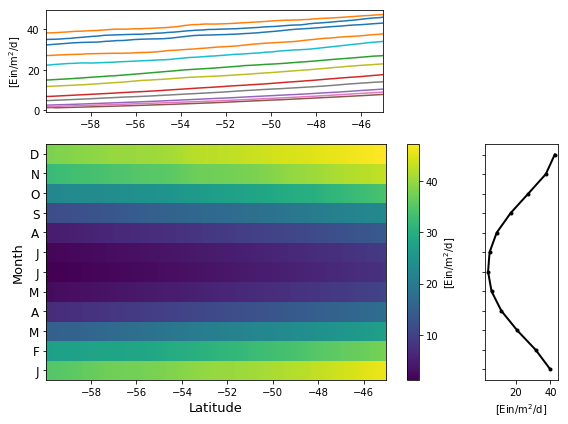

In [33]:
mon = ['J','F','M','A','M','J','J','A','S','O','N','D']

fig = plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(nrows=3,ncols=6)
ax1 = plt.subplot(gs[0,:4])
ax2 = plt.subplot(gs[1:,:5])
ax3 = plt.subplot(gs[1:,5:])
for i in range(12):
    ax1.plot(PAR_mon.sel(lat=slice(-45.,-60.)).lat,PAR_mon.sel(lat=slice(-45.,-60.))[i])
ax1.set_ylabel(r'[Ein/m$^2$/d]')
ax1.set_xlim([PAR_mon.sel(lat=slice(-45.,-60.)).lat.min(),
              PAR_mon.sel(lat=slice(-45.,-60.)).lat.max()])
# ax1.set_xlabel([])
im = ax2.pcolormesh(PAR_mon.sel(lat=slice(-45.,-60.)).lat, range(13), PAR_mon.sel(lat=slice(-45.,-60.)), 
                    rasterized=True)
ax2.set_yticks(np.arange(.5,12.5,1))
ax2.set_yticklabels(mon, fontsize=12)
ax2.set_xlabel(r'Latitude', fontsize=13)
ax2.set_ylabel(r'Month', fontsize=13)
ax3.plot(PAR_mon.sel(lat=slice(-45.,-60.)).mean('lat'), 
         range(1,13), 'k.-', lw=2)
ax3.set_xlabel(r'[Ein/m$^2$/d]')
ax3.set_yticks(range(1,13))
ax3.set_yticklabels([])
cbar = fig.colorbar(im, ax=ax2)
cbar.set_label(r'[Ein/m$^2$/d]')
plt.tight_layout()
# plt.savefig('PAR-SeaWiFS_seasonality.pdf')

In [34]:
print((par_ideal[:,:,np.newaxis]*np.ones(nx)[np.newaxis,np.newaxis,:]).shape)
(par_ideal[:,:,np.newaxis]*np.ones(nx)[np.newaxis,np.newaxis,:]).astype(tp).tofile(output_dir 
                                                                                   + 'PAR_noncos_linear_%03dkm.bin' 
                                                                                   % res)

(12, 1000, 500)


# Generate mask for nutrient relaxation

In [38]:
mask = np.zeros((ny,nx))
nN = int(1e2/res)
nS = int(2e2/res)
if nN>1:
    mask[-nN:] += np.linspace(0.,1.,num=nN)[:,np.newaxis] * np.ones(nx)[np.newaxis,:]
else:
    mask[-1] = 1.
nut_mask = np.tile(mask,(nz,1,1))
nut_mask.shape

(76, 1000, 500)

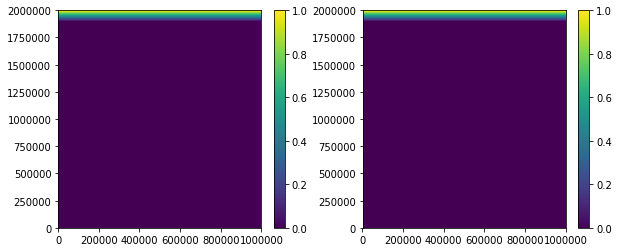

In [39]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
im1 = ax1.pcolormesh(xc,yc,nut_mask[0],vmin=0.,vmax=1.)
im2 = ax2.pcolormesh(xc,yc,nut_mask[1],vmin=0.,vmax=1.)
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)

In [40]:
print(nut_mask.shape)
nut_mask.astype(tp).tofile('/swot/SUM02/takaya/channelMOC-Darwin/rbcs_nut_relax_mask_zero-res_NoSB_%03dkm.bin' % res)

(76, 1000, 500)
